Motorcycle dataset analysis, found at http://vincentarelbundock.github.io/Rdatasets/datasets.html under 'mcycle'

In [1]:
import os
os.chdir('../')

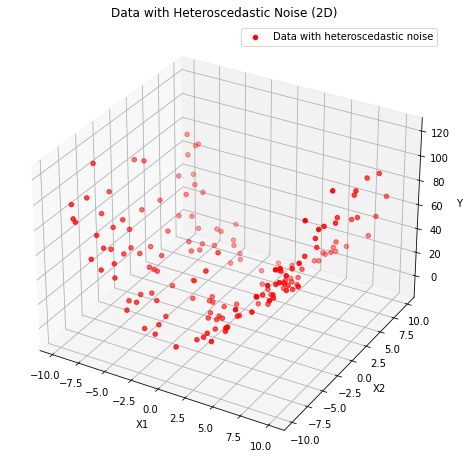

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def quadratic_function(x1, x2, a, b, c):
    return a * x1**2 + b * x2 + c

def add_heteroscedastic_noise(x1, y, noise_factor):
    noise = np.random.normal(0, noise_factor * np.abs(x1), size=y.shape)
    return y + noise

# Generate x1 and x2 values in 2D space
n = 160
x1 = np.random.uniform(-10, 10, n)
x2 = np.random.uniform(-10, 10, n)

# Parameters for the quadratic function
a = 1
b = -1
c = 0

# Generate y values from the quadratic function
y_true = quadratic_function(x1, x2, a, b, c)

# Add heteroscedastic noise to the y values
noise_factor = 1
y_with_noise = add_heteroscedastic_noise(x1, y_true, noise_factor)

# Plot the original quadratic function and the data with noise
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y_with_noise, c='r', marker='o', label='Data with heteroscedastic noise')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('Data with Heteroscedastic Noise (2D)')
plt.legend()
plt.show()

# Create a DataFrame to store the data
data = pd.DataFrame({'x1': x1, 'x2': x2, 'Y': y_with_noise})

# Save the DataFrame to a TSV file
data.to_csv('./modx_data/heteroscedastic_data.tsv', sep='\t', index=False)

In [4]:
import pandas as pd
import GPy
import numpy as np
from hetgp import HetGP
from svgp_multi import SVGPMulti
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
data_dir = './modx_data/'

def regression_metrics(y_true: np.array, y_pred: np.array):

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Mean Squared Error (MSE)': np.float32(mse),
        'Mean Absolute Error (MAE)': np.float32(mae),
        'R-squared (R2)': np.float32(r2),
    }

    return metrics

In [5]:
restarts = 10
n_folds = 5
Ms = ['all'] #, 100]
#These are just starting values, lengthscales will also be randomized
f_rbf_len = 1 # 0.3
f_rbf_var = 0.1 # 0.5
g_rbf_len = 1 # 0.5
g_rbf_var = 0.1 # 0.5

# This is the log of mean of the posterior of the scale parameter, so we set it
# to be the log of roughly what we expect the scale parameter to be if it were
# constant

gauss_noise = 0.1
g_mean_val = None  # np.log(gauss_noise)
g_bias_var = None
f_bias_var = None # ['mean']
fixZ = True
preopt_scg_iters = 100
preopt_restarts = 3
scg_iters = 50
max_iters = 250
num_samples = 100000
gtol = 1e-5
ftol = 0
xtol = 0
starting_df = 4.0
optimize_df = True

fold = 0
seed = 0

name = 'heteroscedastic_data.tsv'

In [6]:
np.random.seed(seed)

In [7]:
from sklearn.model_selection import train_test_split

def read_tsv(path: str, name: str):
    return pd.read_csv(os.path.join(path, name), sep='\t')

def std_matrices(*mts):
    std_mts = []
    for mats in mts:
        if isinstance(mats, np.ndarray):  # Single matrix case
            mats = [mats]
        for mat in mats:
            min_vals = np.min(mat, axis=0)
            max_vals = np.max(mat, axis=0)
            std_mat = (mat - min_vals) / (max_vals - min_vals)
            std_mts.append(std_mat)
    return tuple(std_mts)

def holdout_split(
        df,
        test_size: float = 0.2,
        random_state: int = None,
    ):
    y = df.Y.values
    x = df.values[:, :-1]
    return train_test_split(
            x, y,
            test_size=test_size,
            random_state=random_state
        )

In [8]:
class Dataset(object):
    def __init__(self, Xtrain, Ytrain, Xtest, Ytest):
        self.Xtrain, self.Ytrain, self.Xtest, self.Ytest = Xtrain, Ytrain, Xtest, Ytest

def load_modx(seed):

    df = read_tsv(path=data_dir, name=name)    
    Y = df.Y.values
    X = df.values[:, :-1]
    Xtrain, Xtest, Ytrain, Ytest = std_matrices(
        holdout_split(
            df=read_tsv(path=data_dir, name=name),
            random_state=seed
            )
        )
    Ytrain = Ytrain[:, None]
    Ytest = Ytest[:, None]
    print("training shape: ", Xtrain.shape)
    print("test shape: ", Xtest.shape)
    print("All: ", X.shape)
    print(Xtrain.shape[0] + Xtest.shape[0] - X.shape[0])
    return Dataset(Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest), X, Y

dataset, X, Y = load_modx(seed)

Xtrain = dataset.Xtrain
Ytrain = dataset.Ytrain
Xtest = dataset.Xtest
Ytest = dataset.Ytest

training shape:  (128, 2)
test shape:  (32, 2)
All:  (160, 2)
0


In [9]:
def build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold):
    kernf = GPy.kern.RBF(D, variance=f_rbf_var,
                         lengthscale=np.ones(D)*f_rbf_len, ARD=True,
                         name='kernf_rbf')
    kernf += GPy.kern.White(1, variance=0.001, name='f_white')
    if bias is not None:
        if bias == 'mean':
            f_bias_var = dataset.Ytrain.mean()
        else:
            f_bias_var = bias
            kernf += GPy.kern.Bias(1, variance=f_bias_var, name='f_bias')
    kernf.f_white.fix()
    kernf.name = 'kernf'
    return kernf

def build_kerng(D, g_bias, g_rbf_len, seed, fold):
    # Needs white or variance doesn't checkgrad!
    kerng = GPy.kern.RBF(D, variance=g_rbf_var,
                         lengthscale=np.ones(D)*g_rbf_len, ARD=True,
                         name='kerng_rbf')
    kerng += GPy.kern.White(1, variance=0.001, name='g_white')
    if g_bias is not None:
        kerng += GPy.kern.Bias(1, variance=g_bias, name='g_bias')
    kerng.g_white.fix()
    kerng.name = 'kerng'
    return kerng

from scipy.cluster.vq import kmeans as scipy_kmeans

def kmeans(dataset, k, seed):
    Z, _ = scipy_kmeans(dataset.Xtrain, k)
    return Z

def build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold):
    D = dataset.Xtrain.shape[1]
    kernf = build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold)
    m_gauss = GPy.models.SparseGPRegression(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z=Z.copy(), kernel=kernf)
    m_gauss.name='gauss_single'
    m_gauss.likelihood.variance[:] = gauss_noise
    return m_gauss

def preopt_gauss_scheme(m):
    m.kernf.constrain_positive()
    m.likelihood.variance.constrain_positive()
    if hasattr(m, 'Z'):
        m.Z.fix()
    m.optimize('bfgs', max_iters=preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    if hasattr(m, 'Z'):
        m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    return m

def preopt_gauss(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold):
    m = build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold)
    print("PreOptimizing gauss ", m)
    print(m.kernf.kernf_rbf.lengthscale)
    best_m = preopt_gauss_scheme(m)
    print("Found best gauss model")
    print(best_m)
    return best_m[:]

m1_opt = preopt_gauss(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
m1 = build_gauss_model(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
m1[:] = m1_opt

m1.Z.unfix()
m1.optimize('bfgs', max_iters=3000, messages=1)
print(m1)
print(m1.kernf.kernf_rbf.lengthscale)
mu_gauss, var_gauss = m1.predict(Xtest)

print(mu_gauss)
metrics = regression_metrics(y_true=Ytest, y_pred=mu_gauss)
print(f'train: {metrics}')


reconstraining parameters gauss_single.kernf


PreOptimizing gauss  
Name : gauss_single
Objective : 7.946216685003179
Number of Parameters : 261
Number of Optimization Parameters : 260
Updates : True
Parameters:
  gauss_single.                |     value  |  constraints  |  priors
  inducing_inputs              |  (128, 2)  |               |        
  kernf.kernf_rbf.variance     |       0.1  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |      (2,)  |      +ve      |        
  kernf.f_white.variance       |     0.001  |   +ve fixed   |        
  Gaussian_noise.variance      |       0.1  |      +ve      |        
  index  |  gauss_single.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                1.00000000  |      +ve      |        
  [1]    |                                1.00000000  |      +ve      |        


reconstraining parameters gauss_single.Gaussian_noise.variance


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s16  010  -1.656842e+02   8.751581e+01 
    04s26  036  -1.803152e+02   1.067614e-01 
    06s83  058  -1.805771e+02   2.656590e-07 
Runtime:     06s83
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s62  006  -1.805771e+02   2.597356e-06 
Runtime:     00s62
Optimization status: Converged

Found best gauss model

Name : gauss_single
Objective : -180.57705073502893
Number of Parameters : 261
Number of Optimization Parameters : 261
Updates : True
Parameters:
  gauss_single.                |                  value  |  constraints  |  priors
  inducing_inputs              |               (128, 2)  |               |        
  kernf.kernf_rbf.variance     |     63.958759179177505  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |                   (2,)  |      +ve      |        
  kernf.f_white.variance      

In [10]:
m1.log_predictive_density(Xtest, Ytest).mean()

1.5425715632343049

In [11]:
def random_multi_lengthscales(X_):
    normed_X = (X_.max(0) - X_.min(0))/X_.std(0)
    print(normed_X)
    f_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    g_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    print(f_lengthscales)
    return f_lengthscales, g_lengthscales

In [12]:
# Make the kernels : 
D = dataset.Xtrain.shape[1]
kernf = build_kernf(D, dataset, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
kerng = build_kerng(D, g_bias_var, g_rbf_len, seed, fold)
kern = [kernf, kerng]
mean_functions = [None, None]
likelihood = HetGP()

Z = dataset.Xtrain.copy()

# Make the model : 
m2 = SVGPMulti(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z.copy(), kern_list=kern,
                    likelihood=likelihood, mean_functions=mean_functions, name='multi_gauss')


def pretrain_multi(m, randomize=True):
    if randomize:
        f_lens, g_lens = random_multi_lengthscales(m.X.values)
        m.kernf.kernf_rbf.lengthscale[:] = f_lens
        m.kernf.kernf_rbf.variance[:] = f_rbf_var
        m.kerng.kerng_rbf.lengthscale[:] = g_lens
        m.kerng.kerng_rbf.variance[:] = g_rbf_var
    m.kernf.fix()
    m.kerng.fix()
    if hasattr(m, 'Z'):
        m.Z.fix()
    if hasattr(m, 'constmap'):
        m.constmap.fix()
    print(m)

    # Optimize model with fixed parameters to get latent functions in place
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    
    # Constrain all kernel parameters positive and reoptimize
    m.kernf.constrain_positive()
    m.kerng.constrain_positive()
    m.kernf.f_white.fix()
    m.kerng.g_white.fix()
    
    if hasattr(m, 'constmap'):
        m.constmap.unfix()

    # Continue with optimization with everything released
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)

    return m

m2 = pretrain_multi(m2)

[3.18410423 3.40834737]
[0.01194553 0.00337281]

Name : multi_gauss
Objective : 18511.017942639905
Number of Parameters : 17032
Number of Optimization Parameters : 16768
Updates : True
Parameters:
  multi_gauss.                 |      value  |  constraints  |  priors
  inducing_inputs              |   (128, 2)  |     fixed     |        
  q_u_means                    |   (128, 2)  |               |        
  qf_u_chols                   |  (8256, 2)  |               |        
  kernf.kernf_rbf.variance     |        0.1  |   +ve fixed   |        
  kernf.kernf_rbf.lengthscale  |       (2,)  |   +ve fixed   |        
  kernf.f_white.variance       |      0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |        0.1  |   +ve fixed   |        
  kerng.kerng_rbf.lengthscale  |       (2,)  |   +ve fixed   |        
  kerng.g_white.variance       |      0.001  |   +ve fixed   |        
Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s

reconstraining parameters multi_gauss.kernf



Runtime:     07s44
Optimization status: maxiter exceeded



reconstraining parameters multi_gauss.kerng


Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s16  003   1.297448e+02   8.698394e+01 
    03s25  062   1.207459e+02   4.652882e+02 
    07s29  138   1.033993e+02   7.047642e+02 
    15s40  302   6.921804e+01   5.084542e+02 
Runtime:     15s40
Optimization status: maxiter exceeded

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s19  002   4.781807e+02   1.513111e+07 
    02s22  036   6.006519e+01   4.477335e+02 
    04s27  070   5.103713e+01   1.376636e+02 
    14s55  240   3.980332e+01   1.668122e+01 
    15s59  257   3.954175e+01   1.299977e+01 
    29s92  502   3.905544e+01   1.144004e-01 
Runtime:     29s92
Optimization status: Maximum number of f evaluations reached



In [13]:

m2.Z.unfix()
m2.optimize('bfgs', max_iters=3000, messages=1)
print(m2)
mu_multi_gauss, _ = m2._raw_predict(Xtest, 0)
var_multi_gauss, _ = m2._raw_predict(Xtest, 1)
print(mu_multi_gauss)
metrics = regression_metrics(y_true=Ytest, y_pred=mu_multi_gauss)
print(f'train: {metrics}')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s20  0011   3.905532e+01   7.663644e-01 
    08s73  0044   3.905484e+01   7.386581e-01 
    26s34  0137   3.905369e+01   6.771019e-01 
    39s67  0207   3.905312e+01   4.598032e-01 

 /home/rbarbano/projects/dev/ChainedGP/chained_gp/svgp_multi.py:111: RuntimeWarning:overflow encountered in add


 01m03s76  0339   3.905255e+01   1.052304e+00 
 03m00s07  0958   3.905005e+01   1.366690e-01 
 08m22s16  2673   3.904564e+01   4.409970e-02 
 09m24s56  3002   3.904532e+01   8.211831e-02 
Runtime:  09m24s56
Optimization status: Maximum number of f evaluations reached


Name : multi_gauss
Objective : 39.04532060609999
Number of Parameters : 17032
Number of Optimization Parameters : 17030
Updates : True
Parameters:
  multi_gauss.                 |                  value  |  constraints  |  priors
  inducing_inputs              |               (128, 2)  |               |        
  q_u_means                    |               (128, 2)  |               |        
  qf_u_chols                   |              (8256, 2)  |               |        
  kernf.kernf_rbf.variance     |  3.996013750978922e-06  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |                   (2,)  |      +ve      |        
  kernf.f_white.variance       |                  0.001  |   +ve fixed   |        
  

In [14]:
print(m2.kernf.kernf_rbf.lengthscale)
print(m2.kerng.kerng_rbf.lengthscale)

  index  |  multi_gauss.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                               0.01353554  |      +ve      |        
  [1]    |                               0.00370683  |      +ve      |        
  index  |  multi_gauss.kerng.kerng_rbf.lengthscale  |  constraints  |  priors
  [0]    |                               0.35674882  |      +ve      |        
  [1]    |                               3.08161685  |      +ve      |        


In [15]:
m2.log_predictive_density(Xtest, Ytest).mean()


-0.04713535223438076